# Detecting Distributed Denial of Service (DDoS) Attacks using Machine Learning

This notebook investigates the use of various Python-based machine learning and data science libraries to build a model capable of detecting DDoS attacks in network traffic. The goal is to classify network flows as either benign or DDoS attack traffic based on extracted flow-level features.

We use  CICDDoS2019 dataset and for upcoming work we will combine CICDDOS2019 and  UL-ECE-DDoS-H-IoT-Datasets2025, allowing the model to learn both traditional enterprise network behavior and IoT healthcare network attack patterns.

# We’re going to take the following approach:

* Problem Definition

* Data

* Evaluation

* Features

* Modelling

* Experimentation

# 1. Problem Definition

`Given flow-based network traffic features, can we predict whether a network flow corresponds to a DDoS attack or benign traffic?`

# 2. Data

The data used in this project comes from two publicly available datasets:

1 : CICDDoS2019 Dataset

    Provided by the Canadian Institute for Cybersecurity (CIC)
    
    Contains realistic DDoS attack traffic and benign traffic captured in a controlled environment
    
    Includes multiple DDoS attack types such as SYN flood, UDP flood, DNS, LDAP, MSSQL, SSDP, and others
    
    Flow features are extracted using CICFlowMeter

2: UL-ECE-DDoS-H-IoT-Datasets2025

    Designed for healthcare IoT environments
    
    Contains labeled benign and DDoS traffic over protocols such as MQTT and UDP
    
    Represents modern IoT-based DDoS attack behavior

These two datasets are preprocessed and combined by selecting common numerical flow features and standardizing labels into a binary format.

# 3. Evaluation

If we can achieve high detection accuracy (≥ 95%), along with strong precision, recall, and F1-score, during the proof-of-concept phase, the project will be considered successful and suitable for further research and deployment.

Accuracy alone is not sufficient; therefore, false positives and false negatives are carefully analyzed due to their importance in real-world intrusion detection systems.

# 4. Features

The datasets consist of flow-based network features that describe statistical properties of packet flows between source and destination hosts.

    Sample Data Dictionary (Common Flow Features)
    
    Flow Duration – Total time duration of the flow
    
    Total Fwd Packets – Number of packets sent from source to destination
    
    Total Bwd Packets – Number of packets sent from destination to source
    
    Total Length of Fwd Packets – Total bytes sent forward
    
    Total Length of Bwd Packets – Total bytes sent backward
    
    Flow Bytes/s – Rate of bytes transmitted per second
    
    Flow Packets/s – Rate of packets transmitted per second
    
    Packet Length Mean – Average packet size in the flow
    
    Packet Length Variance – Variability in packet sizes
    
    Fwd Packet Length Mean – Mean packet length in forward direction
    
    Bwd Packet Length Mean – Mean packet length in backward direction
    
    SYN Flag Count – Number of SYN packets (important for SYN flood detection)
    
    ACK Flag Count – Number of ACK packets
    
    PSH / URG Flag Count – Indicators of abnormal traffic behavior
    
    Down/Up Ratio – Ratio of download to upload packets

Target Variable

    `Class`

        Benign
    
        Attack

These features help distinguish normal network behavior from high-volume, abnormal traffic patterns typically generated during DDoS attacks.

# 5. Modelling

    Several machine learning models are trained and evaluated, including:

    Logistic Regression
    
    Random Forest
    
    XGBoost
    
    Support Vector Machine (SVM)
    
    Neural Networks (MLP / LSTM for temporal behavior)
    
    Models are trained on the combined dataset to improve generalization across different network environments.

# 6. Experimentation

    Experiments include:

    Training on the combined dataset
    
    Cross-dataset validation (train on CICDDoS2019, test on IoT dataset)
    
    Feature importance analysis
    
    Performance comparison between classical ML and deep learning models

# Preparing the tools
We're going to use pandas, Matplotlib and NumPy for data analysis and manipulation.

In [37]:
# Importing Libraries For EDA and Plotting 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

# Importing Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluation 
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import RocCurveDisplay

# Loading the Dataset

In [38]:
df=pd.read_csv("dataset/cicddos2019.csv")
df.shape

(431371, 80)

# Data Exploration (exploratory data analysis or EDA)
The goal here is to find out more about the data and become a subject matter export on the dataset you're working with.

    What question(s) are you trying to solve?
    
    What kind of data do we have and how do we treat different types?
    
    What's missing from the data and how do you deal with it?
    
    Where are the outliers and why should you care about them?
    
    How can you add, change or remove features to get more out of your data?

In [39]:
df.head(2)

,Unnamed: 0,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Class
0,0,17,216631,6,0,2088.0,0.0,393.0,321.0,348.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP,Attack
1,1,17,2,2,0,802.0,0.0,401.0,401.0,401.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP,Attack


In [40]:
df.drop("Unnamed: 0",axis=1,inplace=True)

In [41]:
df.head(1)

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Class
0,17,216631,6,0,2088.0,0.0,393.0,321.0,348.0,35.08846,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP,Attack


In [42]:
df.Class.value_counts()

Class
Attack    333540
Benign     97831
Name: count, dtype: int64

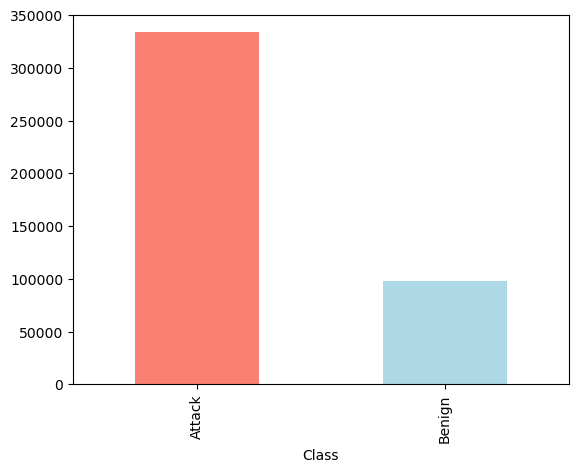

In [43]:
# Lets see visually how many instances of the attack and benign are there
df.Class.value_counts().plot(kind="bar",color=["salmon","lightblue"]);

In [44]:
# Lets compare some of the columns 
df.head(1)

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Class
0,17,216631,6,0,2088.0,0.0,393.0,321.0,348.0,35.08846,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UDP,Attack


In [45]:
# lets first see columns 
df.columns

Index(['Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Fla

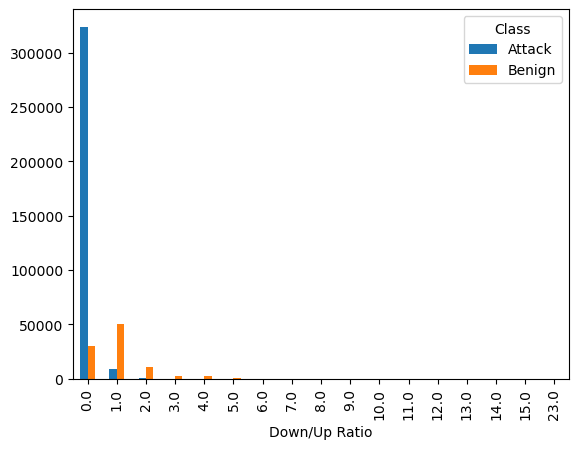

In [46]:
pd.crosstab(df["Down/Up Ratio"],df["Class"]).plot(kind="bar");

In [47]:
pd.crosstab(df["Total Fwd Packets"],df["Class"])

Class,Attack,Benign
Total Fwd Packets,,
1,450,17781
2,37971,45855
3,26,4399
4,103672,6795
5,42,2433
...,...,...
8588,1,0
8624,1,0
20444,0,1


In [48]:
pd.crosstab(df["Total Backward Packets"],df["Class"])

Class,Attack,Benign
Total Backward Packets,,
0,290966,15616
1,138,4121
2,20473,52948
3,89,3130
4,10009,2153
...,...,...
4602,0,1
4632,0,1
6706,0,1


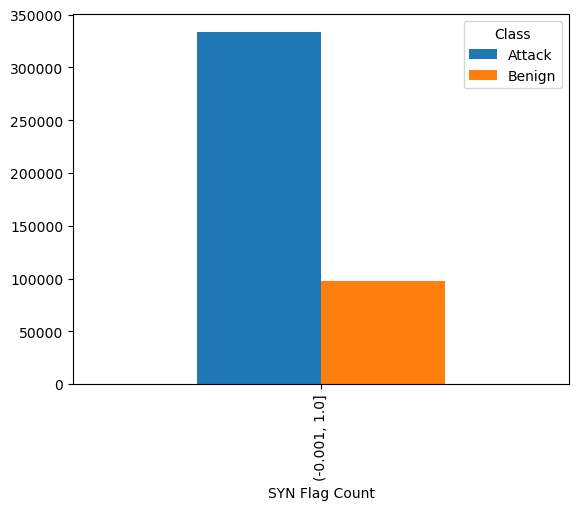

In [49]:
pd.crosstab(pd.qcut(df["SYN Flag Count"], 3, duplicates="drop"), df["Class"]).plot(kind="bar");

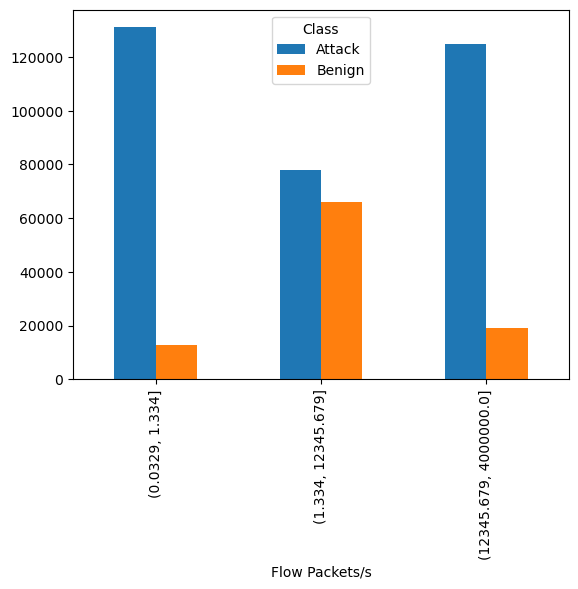

In [50]:
pd.crosstab(pd.qcut(df["Flow Packets/s"], 3), df["Class"]).plot(kind="bar");


# Correlation Matrix 
`Table of Numbers telling us how each independent variable is related to each other  are they : `

* Positively Correlated
* Negatively Correleated
* No Correlation

# As we require numerical features only so first map the strings with numbers 


In [51]:
df["Class"] = df["Class"].map({"Benign": 0, "Attack": 1})
df.drop("Label",axis=1,inplace=True)
df.corr()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Class
Protocol,1.000000,-0.546260,0.035973,-0.062535,0.152277,-0.024154,0.440949,0.652593,0.679051,-0.168704,...,-0.091669,-0.143486,-0.178643,-0.193124,-0.082855,-0.495488,-0.398802,-0.525884,-0.440042,0.436748
Flow Duration,-0.546260,1.000000,-0.007787,0.096673,-0.087828,0.032873,-0.096705,-0.338135,-0.346651,0.211235,...,0.039676,0.203164,0.321709,0.315668,0.082583,0.836919,0.556214,0.865779,0.770099,-0.083947
Total Fwd Packets,0.035973,-0.007787,1.000000,0.176206,0.170466,0.168278,0.042839,0.022465,0.029914,0.006571,...,0.008285,0.004924,0.004869,0.005615,0.003024,-0.003829,-0.013164,-0.006459,-0.000798,0.042735
Total Backward Packets,-0.062535,0.096673,0.176206,1.000000,0.031732,0.973598,0.058295,-0.046526,-0.039123,0.083501,...,0.006218,0.071271,0.063178,0.077078,0.050055,0.099422,0.032709,0.093869,0.101129,-0.063875
Fwd Packets Length Total,0.152277,-0.087828,0.170466,0.031732,1.000000,0.004919,0.254200,0.102811,0.138005,0.037390,...,0.014505,-0.018651,-0.020288,-0.022225,-0.012161,-0.069334,-0.062881,-0.075356,-0.059756,0.130906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Idle Mean,-0.495488,0.836919,-0.003829,0.099422,-0.069334,0.038168,-0.085536,-0.328275,-0.328433,0.212023,...,0.045749,0.210119,0.240709,0.240453,0.118956,1.000000,0.475219,0.978842,0.978561,-0.113193
Idle Std,-0.398802,0.556214,-0.013164,0.032709,-0.062881,0.006292,-0.202960,-0.262195,-0.282959,0.012669,...,0.036829,0.127313,0.247907,0.202731,0.025378,0.475219,1.000000,0.634755,0.291373,0.066460
Idle Max,-0.525884,0.865779,-0.006459,0.093869,-0.075356,0.034193,-0.123848,-0.347899,-0.353206,0.185892,...,0.048559,0.212500,0.268599,0.259028,0.109360,0.978842,0.634755,1.000000,0.919209,-0.081771
Idle Min,-0.440042,0.770099,-0.000798,0.101129,-0.059756,0.040573,-0.041263,-0.292205,-0.286947,0.229254,...,0.040639,0.198847,0.200235,0.210103,0.124453,0.978561,0.291373,0.919209,1.000000,-0.141536


In [55]:
corr_matrix=df.corr()

# Lets make it a bit more Pretty 

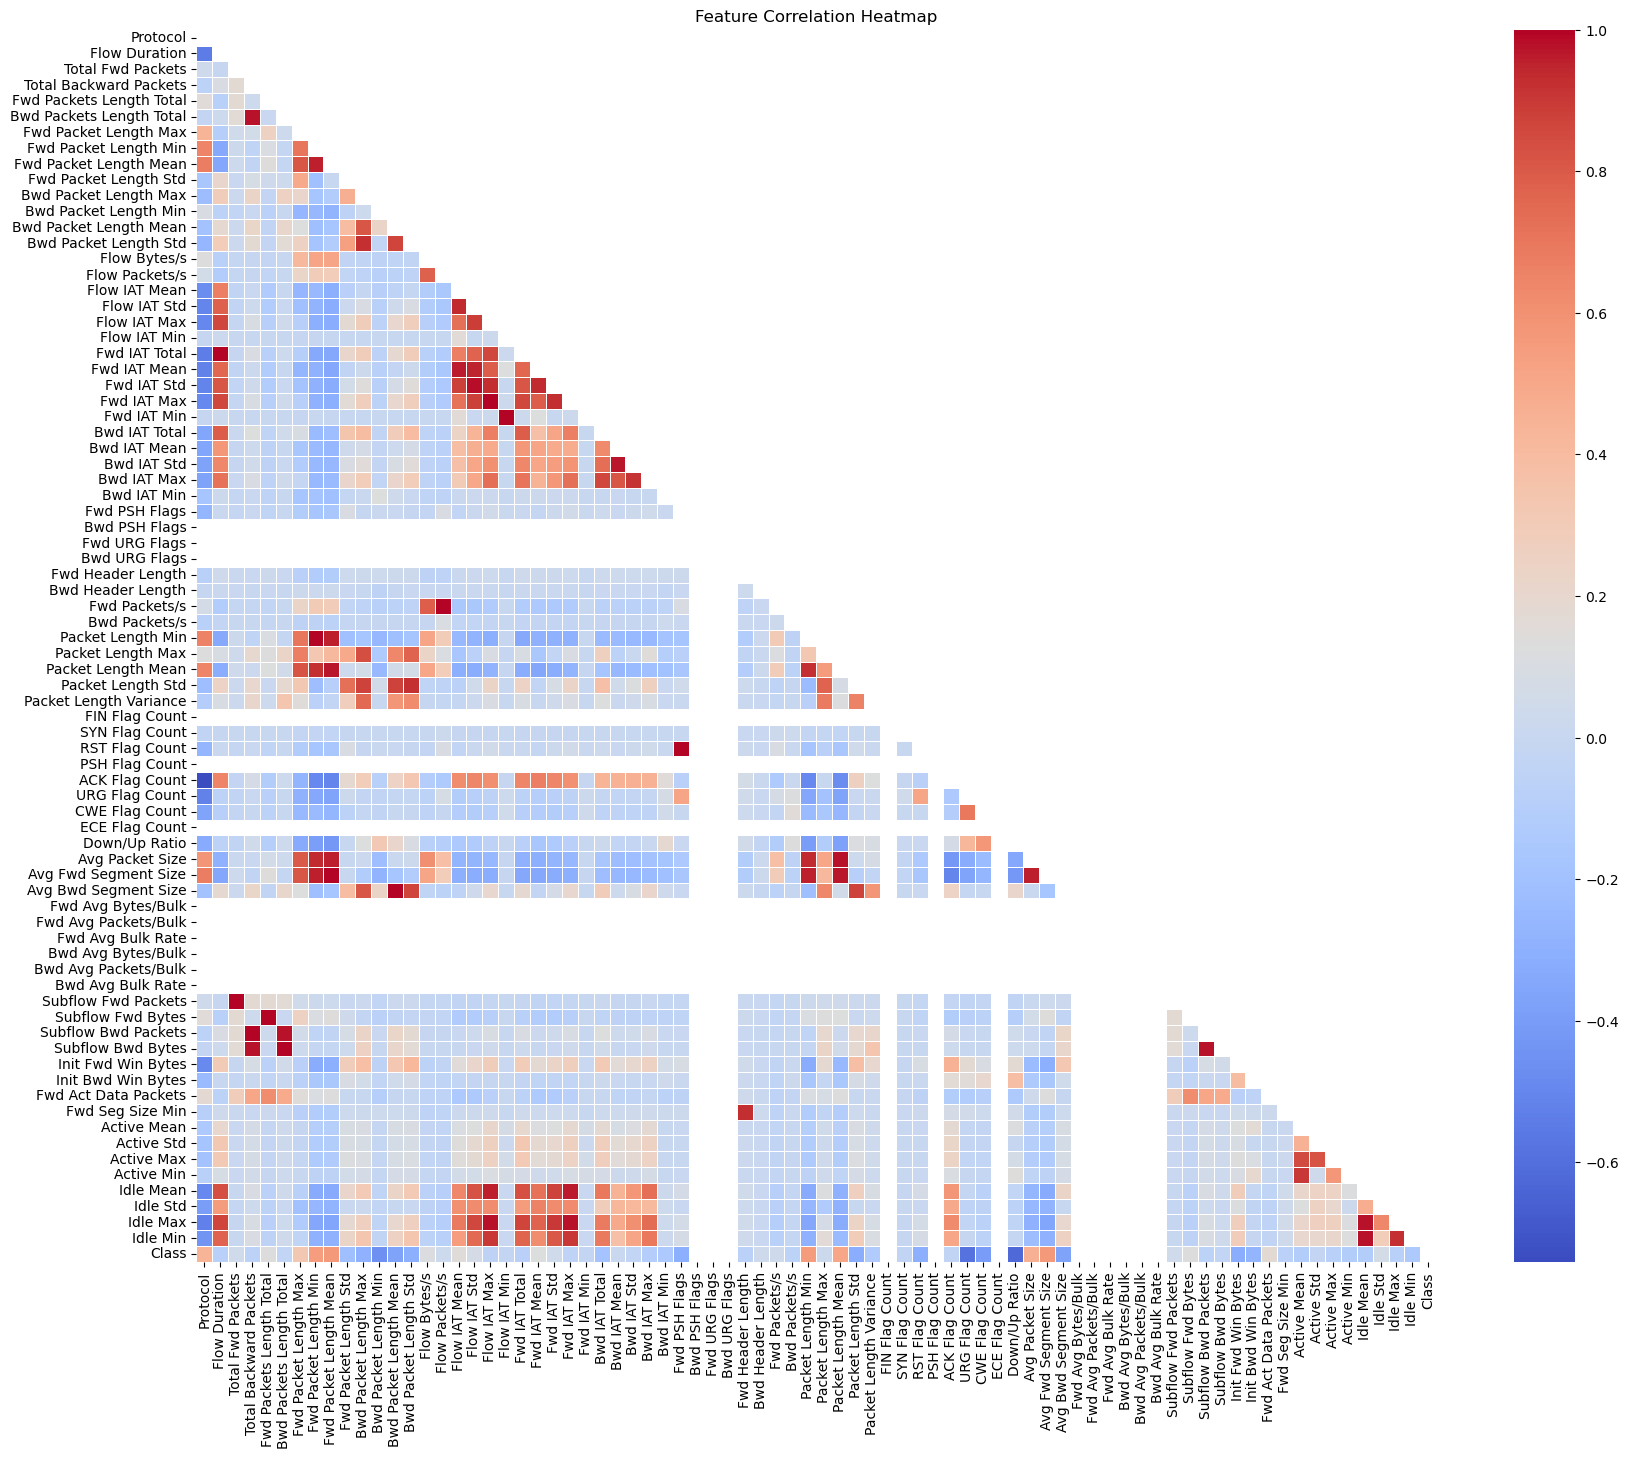

In [62]:
plt.figure(figsize=(20,16))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap="coolwarm", linewidths=0.5, annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()
